In [148]:
import torch

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

In [149]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="data", name="Pubmed")
data = dataset[0]
#setattr(data, 'num_nodes', data.x.shape[0])

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')
print(data)
     

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [150]:
#Neighborhood sample size as described in experimental setup
NEIGHBORHOOD_SAMPLE_SIZE = [25, 10]
#Depth of neighborhood sampling and aggregation
SEARCH_DEPTH = 2
EPOCHS = 100

Subgraph 0: Data(x=[635, 500], edge_index=[2, 800], y=[635], train_mask=[635], val_mask=[635], test_mask=[635], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[313, 500], edge_index=[2, 424], y=[313], train_mask=[313], val_mask=[313], test_mask=[313], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[462, 500], edge_index=[2, 589], y=[462], train_mask=[462], val_mask=[462], test_mask=[462], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[291, 500], edge_index=[2, 381], y=[291], train_mask=[291], val_mask=[291], test_mask=[291], input_id=[12], batch_size=12)


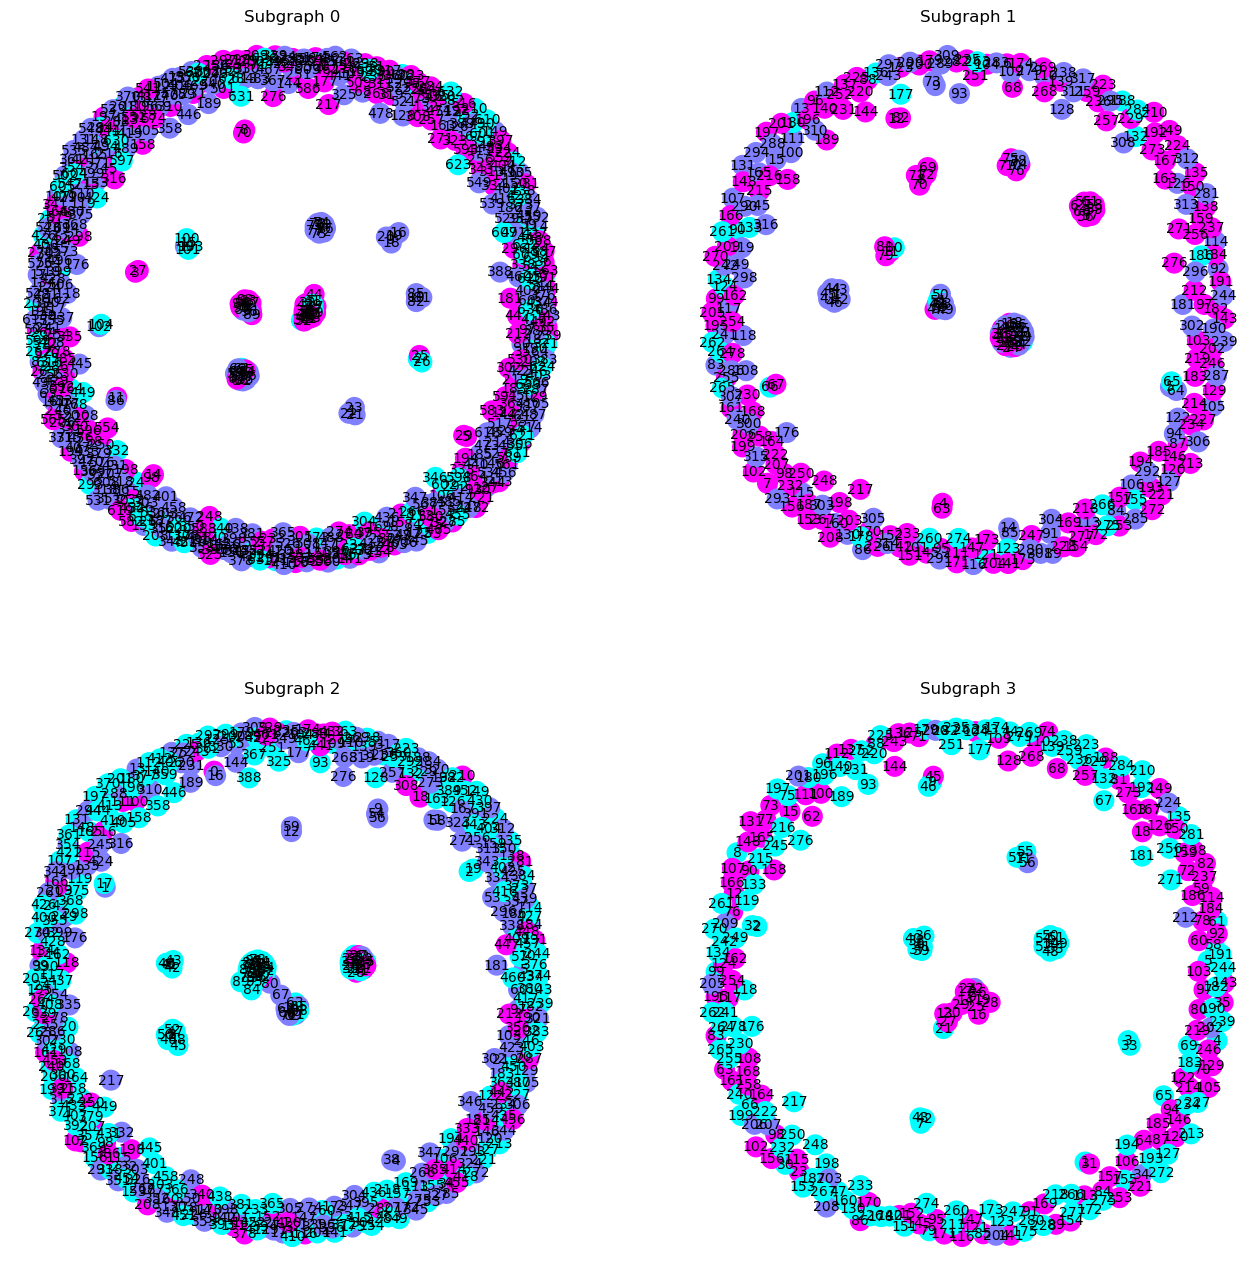

In [151]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=NEIGHBORHOOD_SAMPLE_SIZE,
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

In [152]:
from sklearn.manifold import TSNE

def visualize(h, color, epoch):
    z = TSNE(n_components=2, init='random', learning_rate=200).fit_transform(h.detach().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.savefig(f'bild_{epoch}.png')
    plt.show()

In [153]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv


class GraphSAGE(torch.nn.Module):
  """ 
    GraphSAGE model
    Params:
        in_channels: feature size of each input sample
        hidden_channels: feature size of each hidden sample
        out_channel: feature size of each output sample
        num_layers = K number of message passing layers
        aggregator_type: (mean, pool, lstm)
  """
  def __init__(self, in_channels, hidden_channels, out_channels, aggr='mean'):
    super().__init__()
    self.sage1 = SAGEConv(in_channels, hidden_channels, aggr=aggr)
    self.sage2 = SAGEConv(hidden_channels, hidden_channels, aggr=aggr)
    self.linear = Linear(hidden_channels, out_channels)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)
  """
    Forward Propagation
    Params:
        x: input vector 
        edge_index: list of edges in the graph 
  """
  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu_()
    #h = torch.relu(h)
    #h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    h = self.linear(h)
    return h
    #F.log_softmax(h, dim=1)

In [160]:
def train(model, data, epochs):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = model.optimizer

  model.train()
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    #model.eval()
    #_, out = model(data.x, data.edge_index)
    #visualize(out, data.y, epoch)
    #model.train()

    # Train on batches
    for batch in train_loader:
      optimizer.zero_grad()
      out = model(batch.x, batch.edge_index)
      loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
      total_loss += loss
      acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                      batch.y[batch.train_mask])
      loss.backward()
      optimizer.step()

      # Validation
      val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
      val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                          batch.y[batch.val_mask])

    # Print metrics every 10 epochs
    #if(epoch % 10 == 0):
    print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
          f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
          f'{val_loss/len(train_loader):.2f} | Val Acc: '
          f'{val_acc/len(train_loader)*100:.2f}%')
    

In [161]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc
     


In [167]:
%%time
# Create GraphSAGE
graphsage_mean = GraphSAGE(dataset.num_features, 250, dataset.num_classes)
graphsage_max = GraphSAGE(dataset.num_features, 250, dataset.num_classes, aggr="max")
#print(graphsage_mean)
#print(graphsage_max)
#visualize(data.x, data.y, 0)

# Train
train(graphsage_mean, data, 10)
train(graphsage_max, data, 10)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage_mean, data)*100:.2f}%\n')
print(f'\nGraphSAGE test accuracy: {test(graphsage_max, data)*100:.2f}%\n')
     

Epoch   0 | Train Loss: 0.555 | Train Acc:  33.18% | Val Loss: 1.27 | Val Acc: 22.60%
Epoch   1 | Train Loss: 0.279 | Train Acc:  19.11% | Val Loss: 1.07 | Val Acc: 33.97%
Epoch   2 | Train Loss: 0.240 | Train Acc:  75.21% | Val Loss: 1.07 | Val Acc: 51.74%
Epoch   3 | Train Loss: 0.182 | Train Acc:  88.11% | Val Loss: 0.96 | Val Acc: 54.54%
Epoch   4 | Train Loss: 0.086 | Train Acc:  94.97% | Val Loss: 0.78 | Val Acc: 62.98%
Epoch   5 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 65.96%
Epoch   6 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 77.50%
Epoch   7 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 70.71%
Epoch   8 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 68.90%
Epoch   9 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 73.24%
Epoch  10 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 0.67 | Val Acc: 73.52%
Epoch   0 | Train Loss: 0.484 | Train Acc:  33.18% | V